# Fully Convolutional Networks for semantic segmentation

In an image for the semantic segmentation, each pixcel is labeled with the class of its enclosing object. The semantic segmentation problem requires to make a classification at every pixel.

First, download data from:

https://drive.google.com/file/d/0B0d9ZiqAgFkiOHR1NTJhWVJMNEU/view

and save the downloaded data folder in the current directory.

0001TP_006690.png
seg.shape=(360, 480, 3), img_is.shape=(360, 480, 3)
minimum seg = 0, maximum seg = 11, Total number of segmentation classes = 12


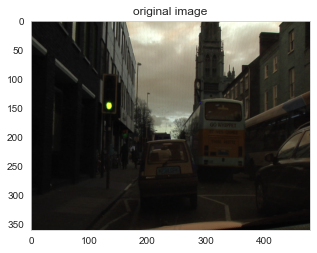

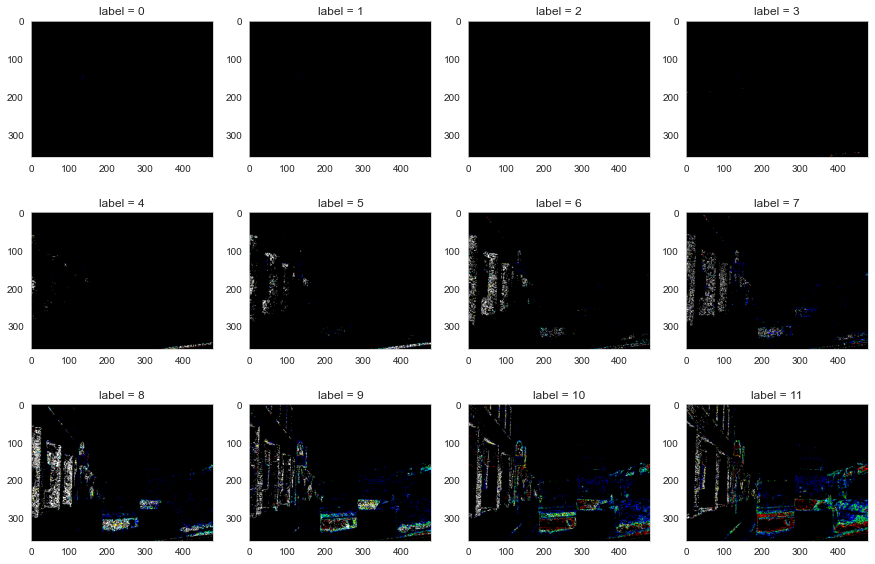

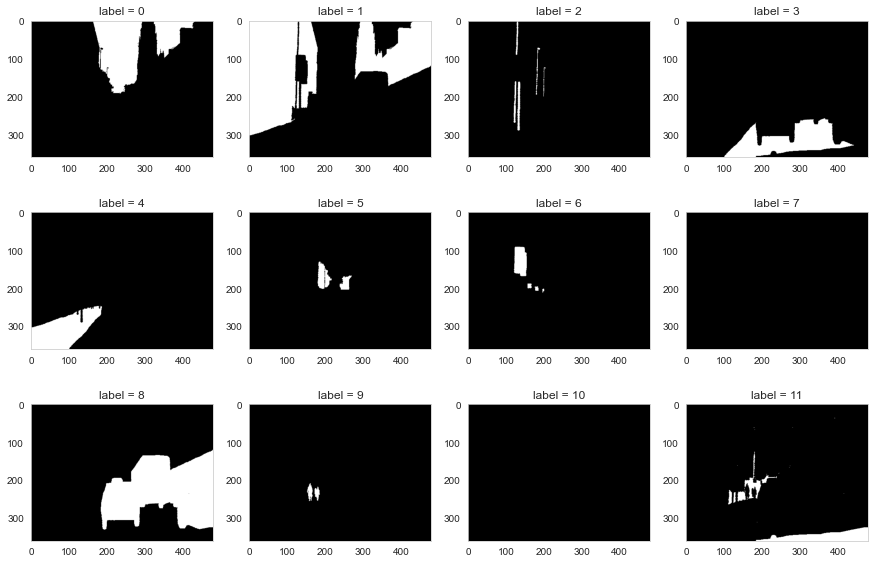

In [35]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})

# enter your path here
dir_data = "dataset1/"
dir_seg = dir_data + "/annotations_prepped_train/"
dir_img = dir_data + "/images_prepped_train/"

ldseg = np.array(os.listdir(dir_seg))

## pick the first image file
fnm = ldseg[0]
print(fnm)

## read in the original image and segmentation labels
## Read first image from annotations_prepped_train and images_prepped_train with path "dir_seg +"/"+ fnm"
'''
Your code here
'''
seg =  cv2.imread(dir_seg + fnm )  # image from annotations_prepped_train (360, 480, 3)
img_is =  cv2.imread(dir_img + fnm )# image from images_prepped_train
print("seg.shape={}, img_is.shape={}".format(seg.shape,img_is.shape))

## Check the number of labels
'''
Your code here
'''
mi, ma = np.min(seg), np.max(seg)
n_classes = ma - mi + 1
print("minimum seg = {}, maximum seg = {}, Total number of segmentation classes = {}".format(mi,ma, n_classes))

# Plot original image from images_prepped_train image:
'''
Your code here
'''
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.imshow(img_is)
ax.set_title("original image")
plt.show()

fig = plt.figure(figsize=(15,10))
for k in range(mi,ma+1):
    ax = fig.add_subplot(3,n_classes/3,k+1)
    ax.imshow((img_is == k)*1.0)
    ax.set_title("label = {}".format(k))

plt.show()

# Plot all class from annotations_prepped_train image:
fig = plt.figure(figsize=(15,10))
for k in range(mi,ma+1):
    ax = fig.add_subplot(3,n_classes/3,k+1)
    ax.imshow((seg == k)*1.0)
    ax.set_title("label = {}".format(k))

plt.show()

From the first section, we can see there are 12 segmentation classes and the image is from a driving car.

Assign color to annotations_prepped_train image

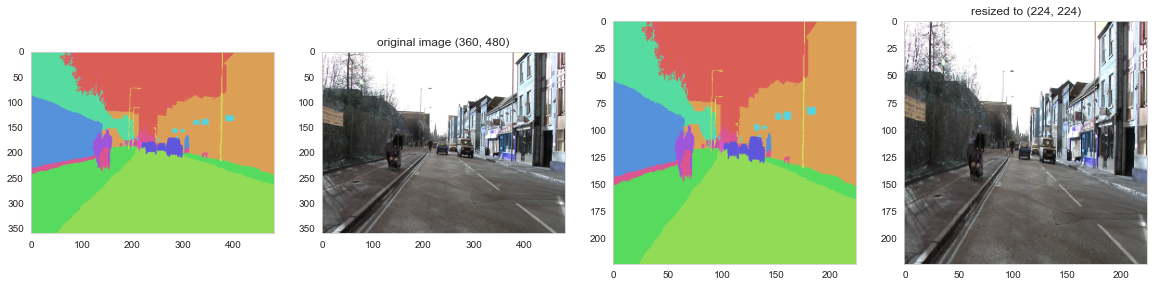

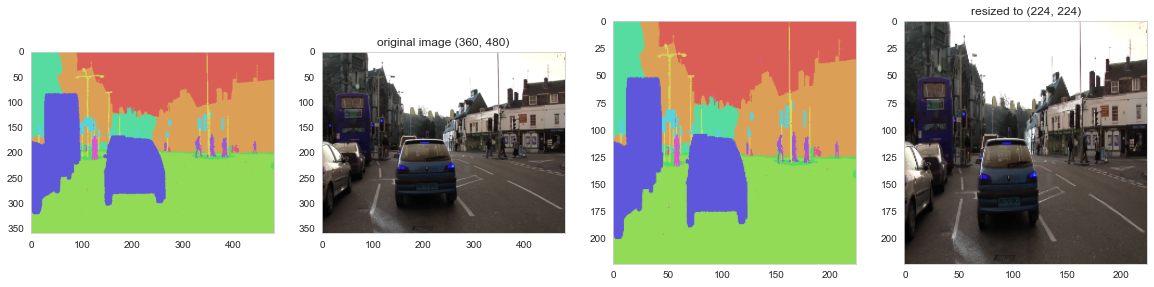

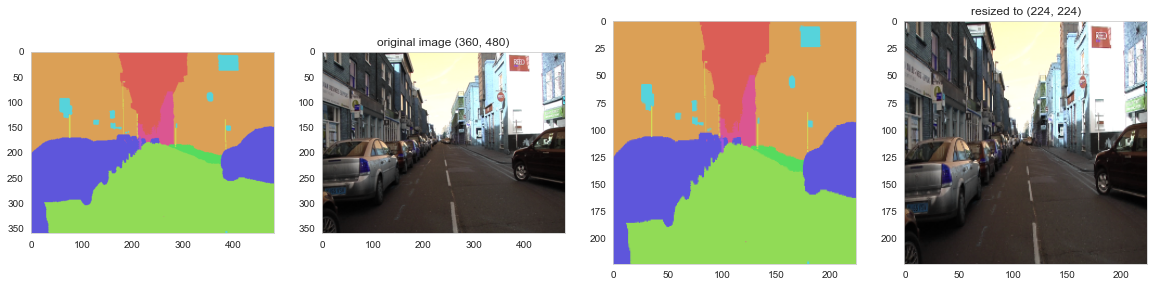

In [36]:
import random
def give_color_to_seg_img(seg,n_classes):
    '''
    seg : size is (input_width,input_height,3)
    assign color to each class 
        You can use sns color palette to assign color pattern
        colors = sns.color_palette("hls", n_classes)
    '''
    if len(seg.shape)==3:
        seg = seg[:,:,0]
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)

    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))


    return(seg_img)

input_height , input_width = 224 , 224
output_height , output_width = 224 , 224


ldseg = np.array(os.listdir(dir_seg))
for fnm in ldseg[np.random.choice(len(ldseg),3,replace=False)]:
    # randomly select on the training image
    fnm = fnm.split(".")[0]
    seg = cv2.imread(dir_seg  +"/"+ fnm + ".png") # (360, 480, 3)
    img_is = cv2.imread(dir_img  +"/"+ fnm + ".png")
    # assign color to its annotations_prepped_train image
    seg_img = give_color_to_seg_img(seg,n_classes)

    fig = plt.figure(figsize=(20,40))
    ax = fig.add_subplot(1,4,1)
    ax.imshow(seg_img)
    
    ax = fig.add_subplot(1,4,2)
    ax.imshow(img_is/255.0)
    ax.set_title("original image {}".format(img_is.shape[:2]))
    
    ax = fig.add_subplot(1,4,3)
    ax.imshow(cv2.resize(seg_img,(input_height , input_width)))
    
    ax = fig.add_subplot(1,4,4)
    ax.imshow(cv2.resize(img_is,(output_height , output_width))/255.0)
    ax.set_title("resized to {}".format((output_height , output_width)))
    plt.show()

To simplify the problem, I will reshape all the images to the same size: (224,224). 

Since this is the iamge shape used in VGG and FCN model in this blog uses a network that takes advantage of VGG structure. The FCN model becomes easier to explain when the image shape is (224,224).

In [37]:
def getImageArr( path , width , height ):
        img = cv2.imread(path, 1)
        img = np.float32(cv2.resize(img, ( width , height ))) / 127.5 - 1
        return img

def getSegmentationArr( path , nClasses ,  width , height  ):

    seg_labels = np.zeros((  height , width  , nClasses ))
    img = cv2.imread(path, 1)
    img = cv2.resize(img, ( width , height ))
    img = img[:, : , 0]

    for c in range(nClasses):
        seg_labels[: , : , c ] = (img == c ).astype(int)
    ##seg_labels = np.reshape(seg_labels, ( width*height,nClasses  ))
    return seg_labels


images = os.listdir(dir_img)
images.sort()
segmentations  = os.listdir(dir_seg)
segmentations.sort()
    
X = []
Y = []
for im , seg in zip(images,segmentations) :
    X.append( getImageArr(dir_img +"/"+ im , input_width , input_height )  )
    Y.append( getSegmentationArr( dir_seg +"/"+ seg , n_classes , output_width , output_height )  )

X, Y = np.array(X) , np.array(Y)
print(X.shape,Y.shape)

(367, 224, 224, 3) (367, 224, 224, 12)


Import Keras and Tensorflow to develop deep learning FCN models

In [38]:
## Import usual libraries
import tensorflow as tf
from tensorflow.python.keras.backend import set_session
import keras, sys, time, warnings
from keras.models import *
from keras.layers import *
import pandas as pd 
warnings.filterwarnings("ignore")

###############################################

# check python, keras, and tensorflow version
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

python 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
keras version 2.4.3
tensorflow version 2.4.1


# From classifier to dense FCN
The recent successful deep learning models such as VGG are originally designed for classification task. The network stacks convolution layers together with down-sampling layers, such as max-pooling, and then finally stacks fully connected layers. Appending a fully connected layer enables the network to learn something using global information where the spatial arrangement of the input falls away.

# Fully convosutional network
For the segmentation task, however, spatial infomation should be stored to make a pixcel-wise classification. FCN allows this by making all the layers of VGG to convolusional layers.

Fully convolutional indicates that the neural network is composed of convolutional layers without any fully-connected layers usually found at the end of the network. Fully Convolutional Networks for Semantic Segmentation motivates the use of fully convolutional networks by "convolutionalizing" popular CNN architectures e.g. VGG can also be viewed as FCN.

The following method is FCN8 from Fully Convolutional Networks for Semantic Segmentation. It deplicates VGG16 net by discarding the final classifier layer and convert all fully connected layers to convolutions. Output image size is (output_height, output_width) = (224,224).

# Upsampling
The upsampling layer brings low resolution image to high resolution. There are various upsamping methods. This presentation gives a good overview. For example, one may double the image resolution by duplicating each pixcel twice. This is so-called nearest neighbor approach and implemented in Keras's UpSampling2D.

These upsampling layers do not have weights/parameters so the model is not flexible. Instead, FCN8 uses upsampling procedure called backwards convolusion (sometimes called deconvolution) with output stride. This method simply reverses the forward and backward passes of convolution and implemented in Keras's Conv2DTranspose.

In FCN8, the upsampling layer is followed by several skip connections. See details at Fully Convolutional Networks for Semantic Segmentation.

Downloaded VGG16 weights from fchollet's Github:  
https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

This is a massive .h5 file (57MB).

In [39]:
# location of VGG weights
VGG_Weights_path = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [40]:
def FCN8( nClasses ,  input_height=224, input_width=224):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller
    assert input_height%32 == 0
    assert input_width%32 == 0
    IMAGE_ORDERING =  "channels_last" 

    img_input = Input(shape=(input_height,input_width, 3)) ## Assume 224,224,3
    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    pool1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(pool1)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    pool2 = x
    
    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(pool2)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)
    pool3 = x
    
    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(pool3)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x)
    pool4 = x
    
    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)
    pool5 = x
    
    vgg = Model(img_input, pool5)
    vgg.load_weights(VGG_Weights_path)##Loading VGG Weights for the encoder parts of FCN
    
    n = 4096
    # Conv6 - 7
    x = ( Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING))(pool5)
    conv7 = ( Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING))(x)
    
    ## 4 times upsampling for cov7
    conv7_4 = Conv2DTranspose( nClasses , kernel_size=(4,4) ,  strides=(4,4) , use_bias=False, data_format=IMAGE_ORDERING )(conv7)
    
    ## 2 times upsampling for pool3 and 4
    pool4 = Conv2D(nClasses, (1, 1), activation='relu', padding='same', name='pool4_conv', data_format=IMAGE_ORDERING )(pool4)
    pool4_2 = Conv2DTranspose( nClasses , kernel_size=(2,2) ,  strides=(2,2) , use_bias=False, data_format=IMAGE_ORDERING )(pool4)
    
    pool3_1 = Conv2D(nClasses, (1, 1), activation='relu', padding='same', name='pool3_conv', data_format=IMAGE_ORDERING )(pool3)
    
    #combine the upsampling and softmax
    combine = Add(name="add")([pool4_2, pool3_1, conv7_4])
    combine = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False, data_format=IMAGE_ORDERING )(combine)
    combine = (Activation('softmax'))(combine)
    
    # create model and load weight
    model = Model(img_input, combine)

    return model

model = FCN8(nClasses     = n_classes,  
             input_height = 224, 
             input_width  = 224)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

Split between training and testing data

In [41]:
from sklearn.utils import shuffle
train_rate = 0.85
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))
                            
X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(311, 224, 224, 3) (311, 224, 224, 12)
(56, 224, 224, 3) (56, 224, 224, 12)


In [42]:
from keras import optimizers

# Training data
sgd = optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

hist1 = model.fit(X_train,y_train,
                  validation_data=(X_test,y_test),
                  batch_size=32,epochs=10,verbose=2)

Epoch 1/10
10/10 - 232s - loss: 2.5721 - accuracy: 0.0827 - val_loss: 2.4852 - val_accuracy: 0.0828
Epoch 2/10
10/10 - 236s - loss: 2.4844 - accuracy: 0.0867 - val_loss: 2.4834 - val_accuracy: 0.0925
Epoch 3/10
10/10 - 237s - loss: 2.4806 - accuracy: 0.1020 - val_loss: 2.4771 - val_accuracy: 0.1073
Epoch 4/10
10/10 - 234s - loss: 2.4722 - accuracy: 0.1122 - val_loss: 2.4652 - val_accuracy: 0.1179
Epoch 5/10
10/10 - 235s - loss: 2.4515 - accuracy: 0.1295 - val_loss: 2.4305 - val_accuracy: 0.1410
Epoch 6/10
10/10 - 237s - loss: 2.3827 - accuracy: 0.1652 - val_loss: 2.3049 - val_accuracy: 0.2051
Epoch 7/10
10/10 - 231s - loss: 2.1997 - accuracy: 0.2592 - val_loss: 2.0975 - val_accuracy: 0.3092
Epoch 8/10
10/10 - 218s - loss: 1.9635 - accuracy: 0.3305 - val_loss: 2.1472 - val_accuracy: 0.3150
Epoch 9/10
10/10 - 218s - loss: 1.8614 - accuracy: 0.3289 - val_loss: 1.8290 - val_accuracy: 0.3188
Epoch 10/10
10/10 - 226s - loss: 1.7638 - accuracy: 0.3323 - val_loss: 1.7110 - val_accuracy: 0.3229

In [44]:
y_pred = model.predict(X_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_test, axis=3)

def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean IoU: {:4.3f}".format(mIoU))
    
IoU(y_testi,y_predi)

class 00: #TP=  7410, #FP=  2547, #FN=470278, IoU=0.015
class 01: #TP= 38163, #FP= 50217, #FN=624661, IoU=0.054
class 02: #TP=     0, #FP=     0, #FN=29010, IoU=0.000
class 03: #TP=860569, #FP=1843330, #FN= 3259, IoU=0.318
class 04: #TP=     0, #FP=     3, #FN=151180, IoU=0.000
class 05: #TP=   795, #FP=  3056, #FN=248338, IoU=0.003
class 06: #TP=     0, #FP=     1, #FN=31571, IoU=0.000
class 07: #TP=     0, #FP=     2, #FN=43755, IoU=0.000
class 08: #TP=   371, #FP=  3389, #FN=167222, IoU=0.002
class 09: #TP=     0, #FP=     0, #FN=23398, IoU=0.000
class 10: #TP=     0, #FP=     0, #FN=12667, IoU=0.000
class 11: #TP=     0, #FP=     3, #FN=97209, IoU=0.000
_________________
Mean IoU: 0.033
